In [1]:
import numpy as np
import cv2,traceback,time,os
calibrate_path = 'data/calibrate'
if not os.path.exists(calibrate_path):
    os.makedirs(calibrate_path)

# 保存标定文件

In [35]:
cap = cv2.VideoCapture(21)
try:
    while 1:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("cap", frame)
        k = cv2.waitKey(30) & 0xFF 
        if k == 27 or k == ord('q'):
            break
        elif k == ord('s'):
            img_file = os.path.join(calibrate_path,str(int(time.time()))) + '.jpg'
            print(img_file)
            cv2.imwrite(img_file,frame)
except:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()

# 标定板配置

In [3]:
# 标定的角点个数
chess_corner_x = 10 
chess_corner_y = 8  
# 终止条件:迭代30次或移动0.001
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,30,0.001)

obj_p = np.mgrid[:chess_corner_x,:chess_corner_y].T.reshape(-1,2)
z_p = np.zeros((chess_corner_x*chess_corner_y))
obj_p = np.c_[obj_p,z_p].astype(np.float32)  # 保存每个格子的位置，z轴的值为0

obj_points = []  # 真实世界坐标系
img_points = []  # 图像坐标系

# 执行标定

In [5]:
for file in os.listdir(calibrate_path):
    frame = cv2.imread(os.path.join(calibrate_path,file))
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    # 检测棋盘角点像素坐标
    ret, corners = cv2.findChessboardCorners(gray,(chess_corner_x,chess_corner_y),None)
    if ret:
        # 寻找亚像素坐标，窗口大小5*5
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        obj_points.append(obj_p)  # 物点
        img_points.append(corners2)
        frame = cv2.drawChessboardCorners(frame,(chess_corner_x,chess_corner_y),corners2,ret)
    cv2.imshow("cap", frame)
    cv2.waitKey(10)
cv2.destroyAllWindows()

# 获取标定配置

In [6]:
ret,mrx,dist,rvecs,tveces = cv2.calibrateCamera(obj_points,img_points,(chess_corner_x,chess_corner_y),None,None)
if ret:
    print("done!",mrx,dist,rvecs,tveces)
else:
    print("calibration error")

done! [[652.03269997   0.         346.86673998]
 [  0.         650.84148106 272.92085685]
 [  0.           0.           1.        ]] [[-0.02960096  0.34399836 -0.00353582  0.00552718 -0.51799294]] [array([[-0.20943181],
       [-0.19323916],
       [-0.03682123]]), array([[-0.21116662],
       [-0.06585048],
       [ 0.03131757]]), array([[0.24903744],
       [0.17596865],
       [0.09947442]]), array([[ 0.29114709],
       [-0.08727379],
       [ 0.03158754]]), array([[-0.0287772 ],
       [-0.07593957],
       [-0.09329735]]), array([[-0.16306663],
       [-0.07144414],
       [ 0.05048406]]), array([[ 0.21802168],
       [-0.09577403],
       [ 0.06458377]]), array([[-0.27221111],
       [ 0.16789642],
       [ 0.09464297]]), array([[0.00928183],
       [0.22575379],
       [0.05798214]]), array([[-0.01806946],
       [ 0.0731653 ],
       [ 0.06711841]]), array([[0.02571627],
       [0.19496417],
       [0.06461748]]), array([[-0.14309682],
       [ 0.06716581],
       [ 0.07177091

# 保存标定文件

In [7]:
np.savez("res.npz",mtx=mrx,dist=dist)

# 矫正

In [10]:
a = np.load("res.npz")

In [7]:
import pandas as pd
columns_name = ['type', 'truncated', 'occluded', 'alpha', 'bbox_lift', 'bbox_top',
                    'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']
file = "/home/hero576/code/python/yolov5/data/kitti/training/label2/000000.txt"
df = pd.read_csv(file, header=None, sep=' ')
df.columns = columns_name
#df.loc[df.type.isin(['Van','Truck','Tram']),'type']='Car'
df=df[df.type.isin(["Car", "Van", "Truck", "Tram", "Pedestrian", "Person_sitting", "Cyclist", "Misc"])]


In [11]:
# 读取文件
img_file = os.path.join(calibrate_path,os.listdir(calibrate_path)[17])
img = cv2.imread(img_file)
h,  w = img.shape[:2]
# 读取标定文件
mtx,dist = [np.load("res.npz")[i] for i in ['mtx','dist']]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [4]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# 剪裁图像
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imshow('src', dst)
cv2.imshow('dst', dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 计算图片外参

In [12]:
def draw(img, corners, imgpts):
    corner = tuple([int(i) for i in corners[0].ravel()])
    imgpts = [tuple([int(i) for i in imgpts[j].ravel()]) for j in range(3)]
    img = cv2.line(img, corner, imgpts[0], (255,0,0), 5)
    img = cv2.line(img, corner, imgpts[1], (0,255,0), 5)
    img = cv2.line(img, corner, imgpts[2], (0,0,255), 5)
    return img
 
#标定图像
def calibration_photo(photo_path):
    #设置要标定的角点个数
    x_nums = 10                                                          #x方向上的角点个数
    y_nums = 8
    #设置(生成)标定图在世界坐标中的坐标
    world_point = np.zeros((x_nums * y_nums,3),np.float32)            #生成x_nums*y_nums个坐标，每个坐标包含x,y,z三个元素
    world_point[:,:2] = np.mgrid[:x_nums,:y_nums].T.reshape(-1, 2)    #mgrid[]生成包含两个二维矩阵的矩阵，每个矩阵都有x_nums列,y_nums行
                                                                        #.T矩阵的转置
                                                                        #reshape()重新规划矩阵，但不改变矩阵元素
    #设置世界坐标的坐标
    axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
    #设置角点查找限制
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
 
    image = cv2.imread(photo_path)
 
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #查找角点
    ok,corners = cv2.findChessboardCorners(gray,(x_nums,y_nums),)
    #print(ok)
    if ok:
        #获取更精确的角点位置
        exact_corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
 
        #获取外参
        _,rvec, tvec, inliers = cv2.solvePnPRansac(world_point, exact_corners, mtx, dist)
        
        #获得的旋转矩阵是向量，是3×1的矩阵，想要还原回3×3的矩阵，需要罗德里格斯变换Rodrigues，
        rotation_m, _ = cv2.Rodrigues(rvec)#罗德里格斯变换
        # print(rotation_m)
        # print('旋转矩阵是：\n', rvec)
        # print('平移矩阵是:\n', tvec)
        rotation_t = np.hstack([rotation_m,tvec])
        # 旋转矩阵和平移矩阵组成的其次矩阵
        rotation_t_Homogeneous_matrix = np.vstack([rotation_t,np.array([[0, 0, 0, 1]])])
        #print(rotation_t_Homogeneous_matrix)
        
        imgpts, jac = cv2.projectPoints(axis, rvec, tvec, mtx, dist)
        #可视化角点
        img = draw(image, corners, imgpts)
        cv2.imshow('img', img)

calibration_photo(img_file)
cv2.waitKey()
cv2.destroyAllWindows()

## 相机矫正2

In [12]:
import cv2,os
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def get_obj_img_points(image_files,grid=(9,6)):
    object_points=[]
    img_points = []
    for file in image_files:
        img = cv2.imread(file)
        #生成object points
        object_point = np.zeros( (grid[0]*grid[1],3),np.float32 )
        object_point[:,:2]= np.mgrid[0:grid[0],0:grid[1]].T.reshape(-1,2)
        #得到灰度图片
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #得到图片的image points
        ret, corners = cv2.findChessboardCorners(gray, grid, None)
        if ret:
            object_points.append(object_point)
            img_points.append(corners)
    return object_points,img_points
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [42]:
#获取棋盘格图片
cal_img_path = "./data/calibration"
cal_imgs = [os.path.join(cal_img_path,file) for file in os.listdir(cal_img_path)]
#计算object_points,img_points
object_points,img_points = get_obj_img_points(cal_imgs,grid=(9,6))

In [44]:
#校正测试图片
# test_file = os.path.join(cal_img_path,"calibration1.jpg")
test_file = cal_imgs[0]
test_img = cv2.imread(test_file)
undistort_img = cal_undistort(test_img,object_points,img_points)

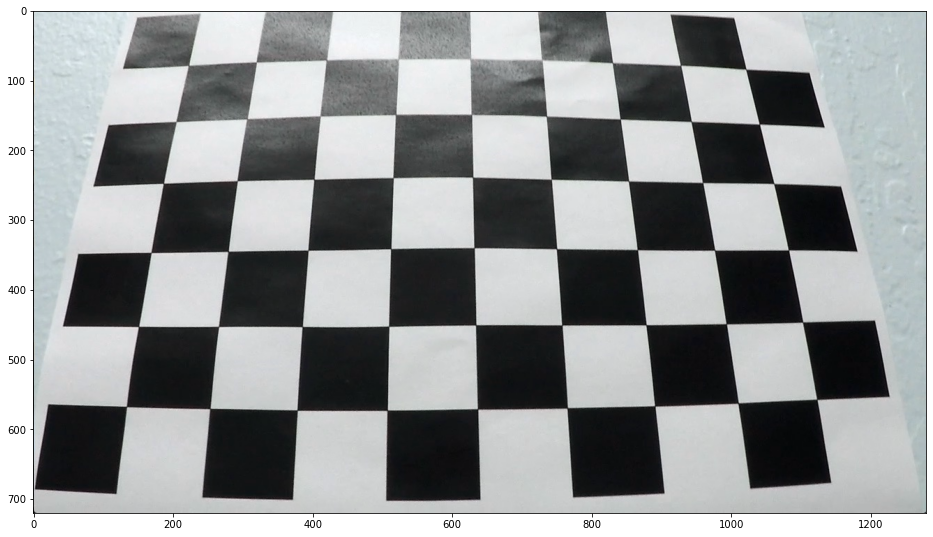

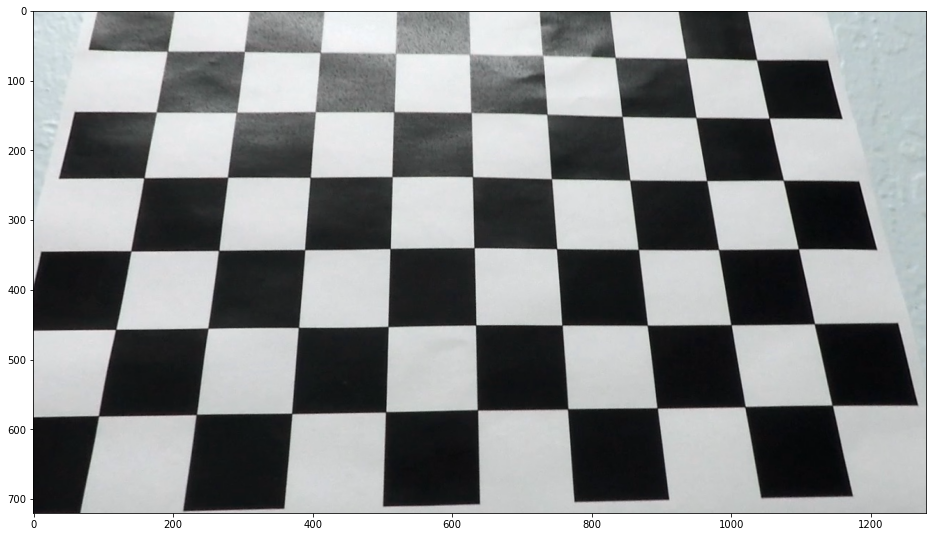

In [45]:
plt.figure(figsize=(16,16))
plt.imshow(test_img)
plt.figure(figsize=(16,16))
plt.imshow(undistort_img)